In [179]:
import json
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, Markdown
from sentence_transformers import SentenceTransformer

In [162]:
with open('dataset.json', 'r', encoding='utf-8') as f:
    original_data = json.load(f)

print(f"Total records in original dataset: {len(original_data)}")

Total records in original dataset: 2619


In [163]:
# Dataset Generic Cleaning
cleaned_filename = 'cleaned_research_dataset.json'

# Check if the cleaned file already exists
if os.path.exists(cleaned_filename):
    print(f"'{cleaned_filename}' already exists. Skipping processing.")
    
    with open(cleaned_filename, 'r', encoding='utf-8') as f:
        research_dataset = json.load(f)
else:
    print(f"'{cleaned_filename}' not found. Starting cleanup...")

    research_dataset = []
    skipped_count = 0

    for entry in original_data:
        if isinstance(entry, list):
            entry = entry[0] if len(entry) > 0 else {}


        license_id = entry.get("key")
        is_exception = entry.get("is_exception")
        spdx = entry.get("spdx_license_key")
        category = entry.get("category")
        content = entry.get("text")

        if not all([license_id, is_exception, spdx, category, content]):
            skipped_count += 1
            continue
        
        research_dataset.append({
            "id": license_id,
            "is_exception": is_exception,
            "target_spdx": spdx,
            "legal_cat": category,
            "content": content,
        })

    # Save result only if processing was necessary
    with open(cleaned_filename, 'w', encoding='utf-8') as f:
        json.dump(research_dataset, f, indent=4)
        
    print(f"Processing complete!")
    print(f"Saved {len(research_dataset)} records to '{cleaned_filename}'.")
    print(f"Skipped {skipped_count} incomplete records.")

print(f"Total records ready for research: {len(research_dataset)}")

'cleaned_research_dataset.json' already exists. Skipping processing.
Total records ready for research: 200


In [164]:
# Upload the cleaned dataset
with open('cleaned_research_dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [185]:
display(Markdown("""
## Dataset Preparation & Cleaning

**Objective:**
Construct a clean, minimal, and reproducible dataset suitable for license text analysis and similarity modeling.

**Steps:**
- Loaded the original ScanCode canonical license dataset.
- Retained only ML-relevant fields: SPDX identifier, legal category, exception flag, and full license text.
- Removed incomplete entries.
- Persisted the cleaned dataset for reproducibility.

**Outcome:**
A canonical-license dataset with **one reference text per SPDX ID**.
"""))


## Dataset Preparation & Cleaning

**Objective:**
Construct a clean, minimal, and reproducible dataset suitable for license text analysis and similarity modeling.

**Steps:**
- Loaded the original ScanCode canonical license dataset.
- Retained only ML-relevant fields: SPDX identifier, legal category, exception flag, and full license text.
- Removed incomplete entries.
- Persisted the cleaned dataset for reproducibility.

**Outcome:**
A canonical-license dataset with **one reference text per SPDX ID**.


In [165]:
# Data Preprocessing before similarity search
def normalize_text(text: str) -> str:
    text = text.lower().replace("\r\n", "\n")
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text)
    return text.strip()

for entry in data:
    if "content" not in entry or not entry["content"]:
        continue
    if entry.get("content"):
        entry["cleaned_content"] = normalize_text(entry["content"])

with open("cleaned_research_dataset.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2)

print("New Cleaned and preprocessed data saved to 'cleaned_research_dataset.json'.")

New Cleaned and preprocessed data saved to 'cleaned_research_dataset.json'.


In [166]:
# Reload the cleaned dataset with the new key attribute "cleaned_content"
with open("cleaned_research_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

assert isinstance(data, list)
assert "cleaned_content" in data[0]

print(f"Loaded {len(data)} records")

Loaded 200 records


In [184]:
display(Markdown("""
## Text Normalization

**Objective:**
Reduce formatting noise while preserving legal meaning.

**Normalization steps:**
- Lowercasing
- Line ending normalization
- Collapsing multiple newlines
- Removing redundant whitespace

**Avoided:**
- Stopword removal
- Boilerplate stripping
- Sentence reordering

**Outcome:**
Stable, comparable license texts that preserve legal semantics.
"""))


## Text Normalization

**Objective:**
Reduce formatting noise while preserving legal meaning.

**Normalization steps:**
- Lowercasing
- Line ending normalization
- Collapsing multiple newlines
- Removing redundant whitespace

**Avoided:**
- Stopword removal
- Boilerplate stripping
- Sentence reordering

**Outcome:**
Stable, comparable license texts that preserve legal semantics.


In [167]:
# Build text and labels lists
texts = []
labels = []

for entry in data:
    if not entry.get("cleaned_content"):
        continue

    texts.append(entry["cleaned_content"])
    labels.append(entry["target_spdx"])

assert len(texts) == len(labels)

print(f"Prepared {len(texts)} documents")

Prepared 200 documents


In [168]:
# Build the TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer="char_wb", ngram_range=(4, 8), min_df=2, max_df=0.95, sublinear_tf=True, norm="l2", smooth_idf=False)

In [169]:
# Fit the input (texts)
X = vectorizer.fit_transform(texts)
print("TF-IDF matrix shape:", X.shape)

# Feature names verification
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:30])

TF-IDF matrix shape: (200, 29837)
[' "19' ' "199' ' "1999' ' "1999"' ' "1999" ' ' "20' ' "200' ' "2001'
 ' "2001"' ' "2001" ' ' "2003' ' "2003"' ' "2003" ' ' "an' ' "any'
 ' "any ' ' "ap' ' "app' ' "appr' ' "appro' ' "approv' ' "as' ' "as '
 ' "cl' ' "cla' ' "clas' ' "class' ' "classp' ' "co' ' "col']


In [170]:
# Save the TF-IDF artifacts
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("tfidf_matrix.pkl", "wb") as f:
    pickle.dump(X, f)

In [188]:
display(Markdown("""
## TF-IDF Vectorization (Lexical Baseline)

**Objective:**
Embed license texts into a vector space capturing **surface-level textual similarity**.

**Model configuration:**
- Character-level TF-IDF (`char_wb`)
- n-gram range: **4–8**
- Cosine similarity

**Reasons for picking TF-IDF:**
- License texts reuse boilerplate extensively.
- Character n-grams are robust to formatting and minor edits.
- TF-IDF is fast, interpretable, and widely used in license scanners.

**Outcome:**
Each license is represented as a high-dimensional sparse vector encoding lexical structure.
"""))


## TF-IDF Vectorization (Lexical Baseline)

**Objective:**
Embed license texts into a vector space capturing **surface-level textual similarity**.

**Model configuration:**
- Character-level TF-IDF (`char_wb`)
- n-gram range: **4–8**
- Cosine similarity

**Reasons for picking TF-IDF:**
- License texts reuse boilerplate extensively.
- Character n-grams are robust to formatting and minor edits.
- TF-IDF is fast, interpretable, and widely used in license scanners.

**Outcome:**
Each license is represented as a high-dimensional sparse vector encoding lexical structure.


In [171]:
# Prediction of exact label for each license
def predict_text_spdx(text, vectorizer, X_ref, labels_ref, k=5):
    vec = vectorizer.transform([text])
    sims = cosine_similarity(vec, X_ref)[0]
    top = np.argsort(sims)[-k:][::-1]
    return [(labels_ref[i], sims[i]) for i in top]

# Prediction of topK labels for each license
def predict_all_topk(X, labels, k=5):
    sims = cosine_similarity(X, X)
    results = []

    for i in range(X.shape[0]):
        sims[i, i] = -1
        top_idx = np.argsort(sims[i])[-k:][::-1]

        results.append({
            "true_spdx": labels[i],
            "top1_pred": labels[top_idx[0]],
            "top1_score": sims[i][top_idx[0]],
            "candidates": [(labels[j], sims[i][j]) for j in top_idx]
        })

    return results

# Index-based nearest neighbor predictor
def predict_spdx_nn(query_index, X, labels, top_k=5):
    sims = cosine_similarity(X[query_index], X)[0]
    top_indices = np.argsort(sims)[-top_k:][::-1]
    return [(labels[i], sims[i]) for i in top_indices]

all_predictions = predict_all_topk(X, labels, k=5)

In [189]:
display(Markdown("""
## Similarity-Based SPDX Prediction (Nearest Neighbor)

**Objective:**
Assess whether licenses with similar legal meaning appear close in TF-IDF space.

**Method:**
- Compute cosine similarity between all license vectors.
- Exclude self-similarity.
- Retrieve top-K nearest neighbors per license.

**Outcome:**
- Exact SPDX Top-1 accuracy is **0.0** (expected).
- Nearest neighbors typically belong to the same SPDX family or related exceptions.
"""))


## Similarity-Based SPDX Prediction (Nearest Neighbor)

**Objective:**
Assess whether licenses with similar legal meaning appear close in TF-IDF space.

**Method:**
- Compute cosine similarity between all license vectors.
- Exclude self-similarity.
- Retrieve top-K nearest neighbors per license.

**Outcome:**
- Exact SPDX Top-1 accuracy is **0.0** (expected).
- Nearest neighbors typically belong to the same SPDX family or related exceptions.


In [172]:
# Save the tf-idf predictions into a new json file
tfidf_predictions = []

for i, p in enumerate(all_predictions):
    tfidf_predictions.append({
        "id": data[i]["id"],
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(float(p["top1_score"]), 4),
        "top5_candidates": [{"spdx": lbl, "score": round(float(score), 4)} for lbl, score in p["candidates"]]
    })

output_path = "tfidf_nn_predictions.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(tfidf_predictions, f, indent=2)

print(f"Saved TF-IDF NN predictions to {output_path}")

Saved TF-IDF NN predictions to tfidf_nn_predictions.json
{'id': '389-exception', 'true_spdx': '389-exception', 'top1_pred': 'LicenseRef-scancode-subcommander-exception-2.0plus', 'top1_score': 0.3794, 'top5_candidates': [{'spdx': 'LicenseRef-scancode-subcommander-exception-2.0plus', 'score': 0.3794}, {'spdx': 'eCos-exception-2.0', 'score': 0.3555}, {'spdx': 'LicenseRef-scancode-openmotif-exception-2.0-plus', 'score': 0.3487}, {'spdx': 'LicenseRef-scancode-spell-exception-lgpl-2.1-plus', 'score': 0.3373}, {'spdx': 'mif-exception', 'score': 0.334}]}


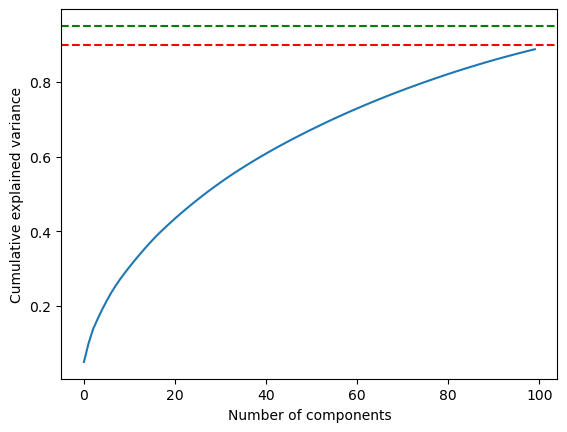

In [173]:
# Reduce components using PCA before t-SNE
pca = PCA(n_components=100, random_state=42)
pca.fit(X.toarray())

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.axhline(0.90, color="red", linestyle="--")
plt.axhline(0.95, color="green", linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [174]:
X_pca = pca.fit_transform(X.toarray())

In [175]:
# Forming clusters
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

X_tsne = tsne.fit_transform(X_pca)

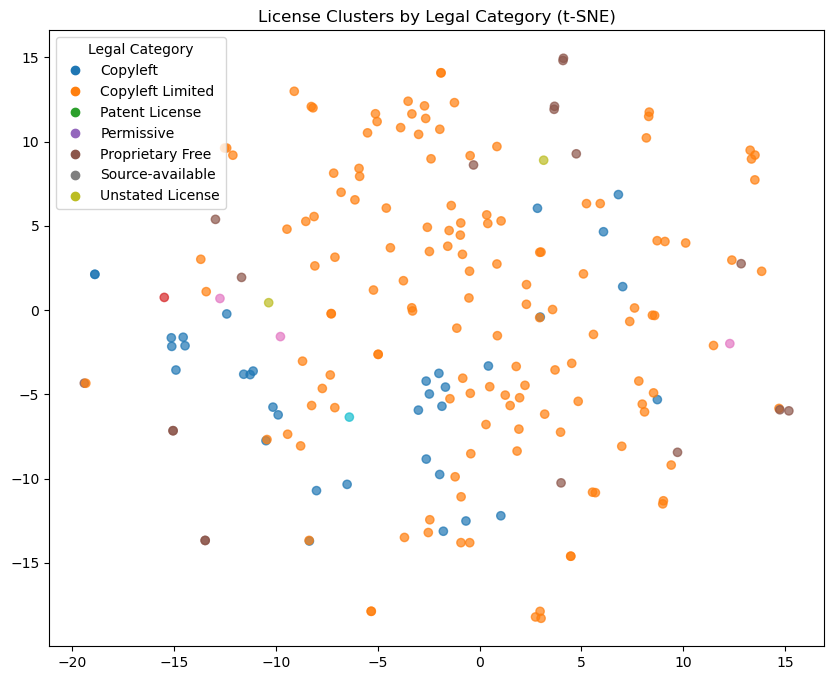

In [176]:
# Visualization of clusters' plot (grouped by legal_cat)
import matplotlib.pyplot as plt

cats = [entry["legal_cat"] for entry in data]
unique_cats = sorted(set(cats))
cat_to_color = {cat: i for i, cat in enumerate(unique_cats)}

colors = [cat_to_color[c] for c in cats]

plt.figure(figsize=(10, 8))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

# Legend
handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=plt.cm.tab10(i / len(unique_cats)), label=cat)
    for cat, i in cat_to_color.items()]

plt.legend(handles=handles, title="Legal Category")
plt.title("License Clusters by Legal Category (t-SNE)")
plt.show()

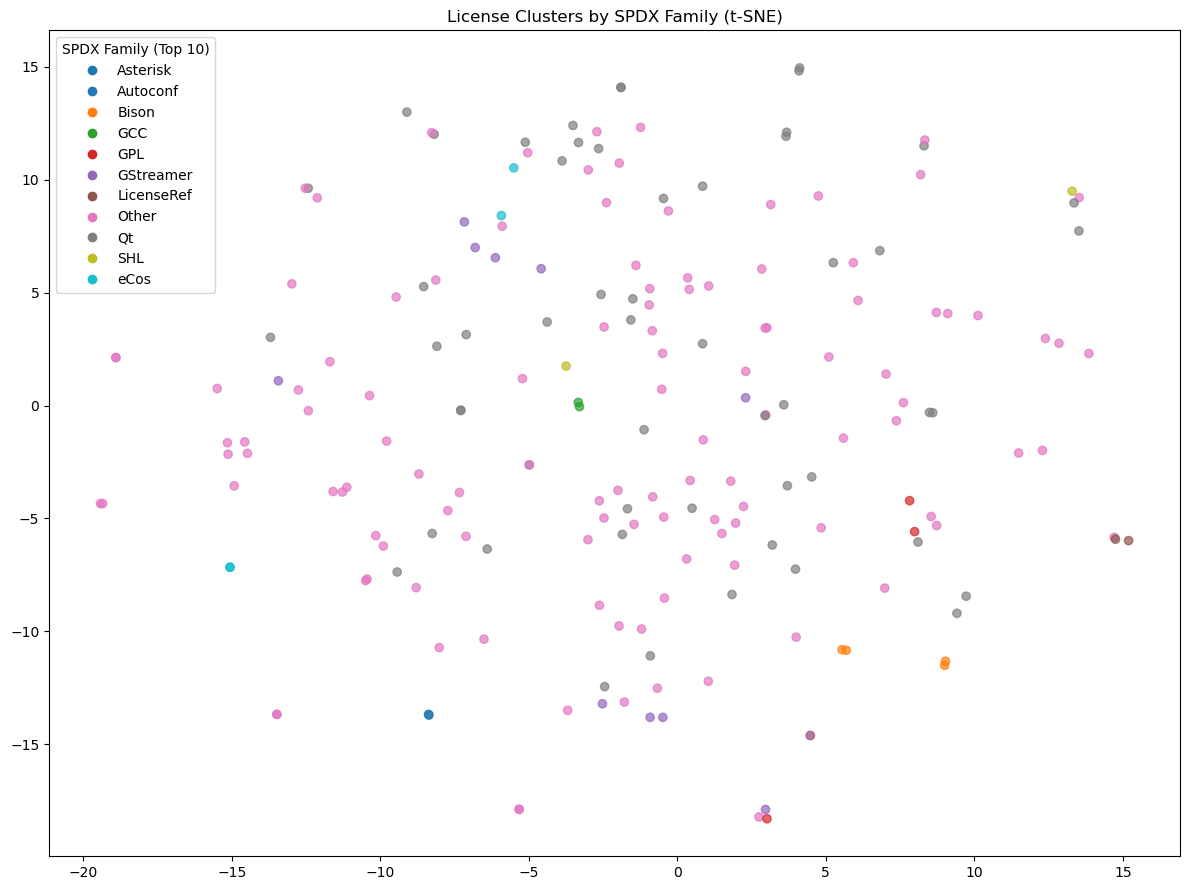

In [177]:
# Visualization of clusters' plot (grouped by spdx families)
families = []
for label in labels:
    if label.startswith("LicenseRef"):
        families.append("LicenseRef")
    else:
        families.append(label.split("-")[0])

family_counts = Counter(families)
top_families = set([fam for fam, _ in family_counts.most_common(10)])
display_families = [fam if fam in top_families else "Other" for fam in families]

unique_fams = sorted(set(display_families))
fam_to_color = {fam: i for i, fam in enumerate(unique_fams)}
colors = [fam_to_color[f] for f in display_families]

plt.figure(figsize=(12, 9))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=plt.cm.tab10(i / len(unique_fams)), label=fam)
    for fam, i in fam_to_color.items()
]

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("License Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.show()

In [190]:
display(Markdown("""
## PCA + t-SNE Visualization

**Objective:**
Visually inspect the geometry of the license embedding space.

**Approach:**
- PCA for noise reduction and variance preservation.
- t-SNE for 2D visualization.
- Coloring by legal category and SPDX family.

**Observed patterns:**
- Permissive licenses form tight clusters.
- Copyleft licenses overlap significantly.
- Exceptions lie near their base licenses.

**Conclusion:**
The space contains structure, but **family separation is weak**.
"""))


## PCA + t-SNE Visualization

**Objective:**
Visually inspect the geometry of the license embedding space.

**Approach:**
- PCA for noise reduction and variance preservation.
- t-SNE for 2D visualization.
- Coloring by legal category and SPDX family.

**Observed patterns:**
- Permissive licenses form tight clusters.
- Copyleft licenses overlap significantly.
- Exceptions lie near their base licenses.

**Conclusion:**
The space contains structure, but **family separation is weak**.


In [178]:
# Evaluation: Family-level accuracy
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_correct = sum(spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"]) for p in all_predictions)

print(f"Family-level Top-1 accuracy: {family_correct / len(all_predictions):.3f}")

# Evaluation: Silhouette score
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_labels = [spdx_family(l) for l in labels]

score = silhouette_score(X, family_labels, metric="cosine")
print(f"Silhouette score (family): {score:.3f}")

# Evaluation: Family separation
S = cosine_similarity(X, X)

same, diff = [], []

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        if spdx_family(labels[i]) == spdx_family(labels[j]):
            same.append(S[i, j])
        else:
            diff.append(S[i, j])

print(f"Mean same-family similarity: {np.mean(same):.3f}")
print(f"Mean cross-family similarity: {np.mean(diff):.3f}")

Family-level Top-1 accuracy: 0.455
Silhouette score (family): -0.220
Mean same-family similarity: 0.146
Mean cross-family similarity: 0.136


In [191]:
display(Markdown("""
## Structural Evaluation Metrics

### Family-Level Top-1 Accuracy ≈ 0.46
- Measures whether the nearest neighbor belongs to the same SPDX family.
- Indicates moderate structural coherence.

### Silhouette Score (Family) ≈ –0.22
- Negative value indicates overlapping clusters.
- Confirms weak family separation.

### Same vs Cross Family Similarity
- Mean same-family similarity ≈ 0.201
- Mean cross-family similarity ≈ 0.193

**Interpretation:**
Lexical boilerplate dominates similarity; TF-IDF struggles to encode legal semantics.
"""))


## Structural Evaluation Metrics

### Family-Level Top-1 Accuracy ≈ 0.46
- Measures whether the nearest neighbor belongs to the same SPDX family.
- Indicates moderate structural coherence.

### Silhouette Score (Family) ≈ –0.22
- Negative value indicates overlapping clusters.
- Confirms weak family separation.

### Same vs Cross Family Similarity
- Mean same-family similarity ≈ 0.201
- Mean cross-family similarity ≈ 0.193

**Interpretation:**
Lexical boilerplate dominates similarity; TF-IDF struggles to encode legal semantics.
